In [1]:
# Nos conectamos al Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Cambiar el directorio de trabajo
import os
os.chdir('/content/drive/My Drive/BCRP/input')

# Mostrar el directorio actual de trabajo
print("Directorio actual:", os.getcwd())

# Listar todos los archivos y carpetas en el directorio actual
print("\nArchivos y carpetas en el directorio actual:")
print(os.listdir())

!ls "/content/drive/My Drive/BCRP/input"

Directorio actual: /content/drive/My Drive/BCRP/input

Archivos y carpetas en el directorio actual:
['Usoactual_AMAZONAS.dbf', 'Usoactual_AMAZONAS.shx', 'Usoactual_LAMBAYEQUE.dbf', 'Usoactual_LAMBAYEQUE.sbx', 'Usoactual_LAMBAYEQUE.shp', 'Usoactual_LAMBAYEQUE.prj', 'Usoactual_LAMBAYEQUE.sbn', 'Usoactual_LAMBAYEQUE.shx', 'Usoactual_LAMBAYEQUE.shp.xml', 'Usoactual_PIURA.prj', 'Usoactual_PIURA.shp', 'Usoactual_PIURA.sbx', 'Usoactual_PIURA.sbn', 'Usoactual_PIURA.shx', 'Usoactual_PIURA.dbf', 'Usoactual_PIURA.shp.xml', 'Lima_Hectareas_Senasa.xlsx', 'INEI_LIMITE_DEPARTAMENTAL.shp', 'INEI_LIMITE_DISTRITAL.shp', 'INEI_LIMITE_DEPARTAMENTAL.cpg', 'INEI_LIMITE_DEPARTAMENTAL.shp.xml', 'INEI_LIMITE_DEPARTAMENTAL.dbf', 'INEI_LIMITE_DEPARTAMENTAL.prj', 'INEI_LIMITE_DEPARTAMENTAL.sbn', 'INEI_LIMITE_DEPARTAMENTAL.sbx', 'INEI_LIMITE_DISTRITAL.cpg', 'INEI_LIMITE_DISTRITAL.dbf', 'INEI_LIMITE_DISTRITAL.prj', 'INEI_LIMITE_DISTRITAL.sbn', 'INEI_LIMITE_DISTRITAL.sbx', 'INEI_LIMITE_DISTRITAL.shx', 'INEI_LIMITE_P

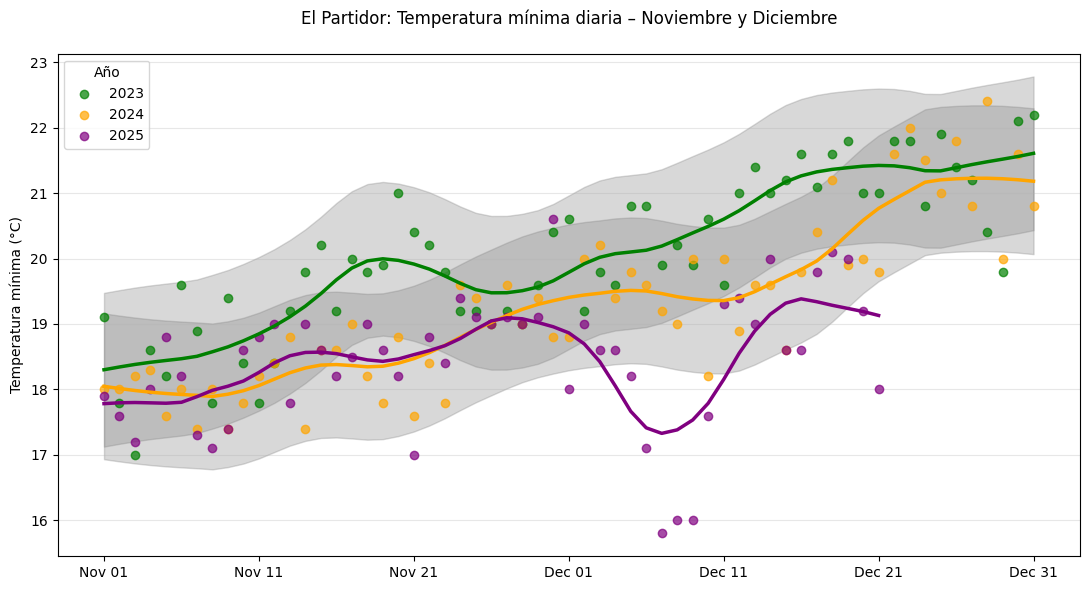

In [5]:
# --- Temperatura mínima diaria Nov–Dic (2023–2025)
# Puntos + tendencia flexible (LOWESS) + bandas grises
# Colores: 2023 verde, 2024 naranja, 2025 morado
# Listo para Google Colab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Si no tienes statsmodels en Colab, descomenta la siguiente línea:
# !pip -q install statsmodels

from statsmodels.nonparametric.smoothers_lowess import lowess

# 1) Cargar archivo (ajusta la ruta si tu archivo está en Drive)
file_path  = '/content/drive/My Drive/BCRP/input/atm.xlsx'

df = pd.read_excel(file_path)

# 2) Pasar a formato largo: columnas [fecha, anio, temp_min]
df_long = df.melt(id_vars="fecha", var_name="anio", value_name="temp_min")
df_long["anio"] = df_long["anio"].astype(int)
df_long["fecha"] = pd.to_datetime(df_long["fecha"])

# 3) Índice de día alineado Nov–Dic (1..N) por año (ojo: fecha en excel puede ser 2025, pero sirve como “calendario”)
df_long["dia"] = df_long.groupby("anio")["fecha"].transform(
    lambda x: (x - x.min()).dt.days + 1
)

colors = {2023: "green", 2024: "orange", 2025: "purple"}

plt.figure(figsize=(11, 6))

for year, color in colors.items():
    sub = df_long[df_long["anio"] == year].sort_values("dia")
    x = sub["dia"].to_numpy()
    y = sub["temp_min"].to_numpy()

    # Puntos
    plt.scatter(x, y, color=color, alpha=0.7, label=str(year), zorder=3)

    # Tendencia flexible (LOWESS)
    # frac controla qué tan suave es (0.20–0.35 suele ir bien)
    low = lowess(y, x, frac=0.25, return_sorted=True)
    x_s = low[:, 0]
    y_s = low[:, 1]

    # Banda gris (aprox): usa desviación estándar de residuales vs LOWESS
    y_interp = np.interp(x, x_s, y_s)
    resid = y - y_interp
    sigma = resid.std(ddof=1)

    plt.fill_between(
        x_s,
        y_s - 1.96 * sigma,
        y_s + 1.96 * sigma,
        color="gray",
        alpha=0.30,
        zorder=1
    )

    # Línea LOWESS
    plt.plot(x_s, y_s, color=color, linewidth=2.5, zorder=4)

# 4) Eje X con etiquetas Nov/Dic (evitando el choque Nov30 vs Dic01)
base_dates = pd.to_datetime(df["fecha"])  # usa las fechas “plantilla” del excel

ticks = []
labels = []
for d in base_dates:
    # Elegimos días para que no se encimen:
    # Nov: 1,11,21 ; Dic: 1,11,21,31
    if (d.month == 11 and d.day in [1, 11, 21]) or (d.month == 12 and d.day in [1, 11, 21, 31]):
        day_idx = (d - base_dates.min()).days + 1
        ticks.append(day_idx)
        labels.append(d.strftime("%b %d"))

plt.xticks(ticks, labels)

# 5) Estética final
plt.xlabel("")  # sin “Día calendario”
plt.ylabel("Temperatura mínima (°C)")
plt.title("El Partidor: Temperatura mínima diaria – Noviembre y Diciembre\n")
plt.legend(title="Año")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
